In [3]:
import os.path
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import seaborn as sns 

from pathlib import Path 
from tqdm import tqdm 
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from IPython.display import Markdown, display

In [4]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
train_df = pd.DataFrame({"file" : os.listdir("/home/kkyu/amr_ws/DL/data/shape_figure/train")})
train_df["label"] = train_df["file"].apply(lambda x: x.split(".")[0])
train_df["label"] = train_df["label"].str.split("_").str.get(0)

train_df

,file,label
0,star_27.jpg,star
1,star_799.jpg,star
2,rec_666.jpg,rec
3,cir_428.jpg,cir
4,rec_1000036.jpg,rec
...,...,...
796,tri_37.jpg,tri
797,cir_435.jpg,cir
798,tri_540.jpg,tri
799,cir_27.jpg,cir


In [8]:
print(train_df.shape[0])
print(len(train_df.label.unique()))
print(train_df.label.unique())

801
4
['star' 'rec' 'cir' 'tri']


/tmp/ipykernel_47657/994124874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="label", palette='Set3')


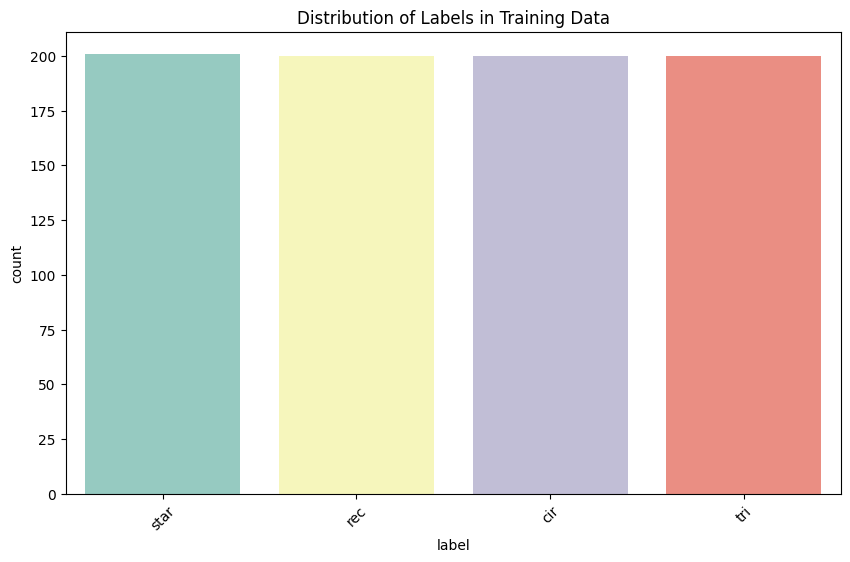

In [16]:
plt.figure(figsize=(10, 6))

sns.countplot(data=train_df, x="label", palette='Set3')

plt.title('Distribution of Labels in Training Data')

plt.xticks(rotation=45)
plt.show()


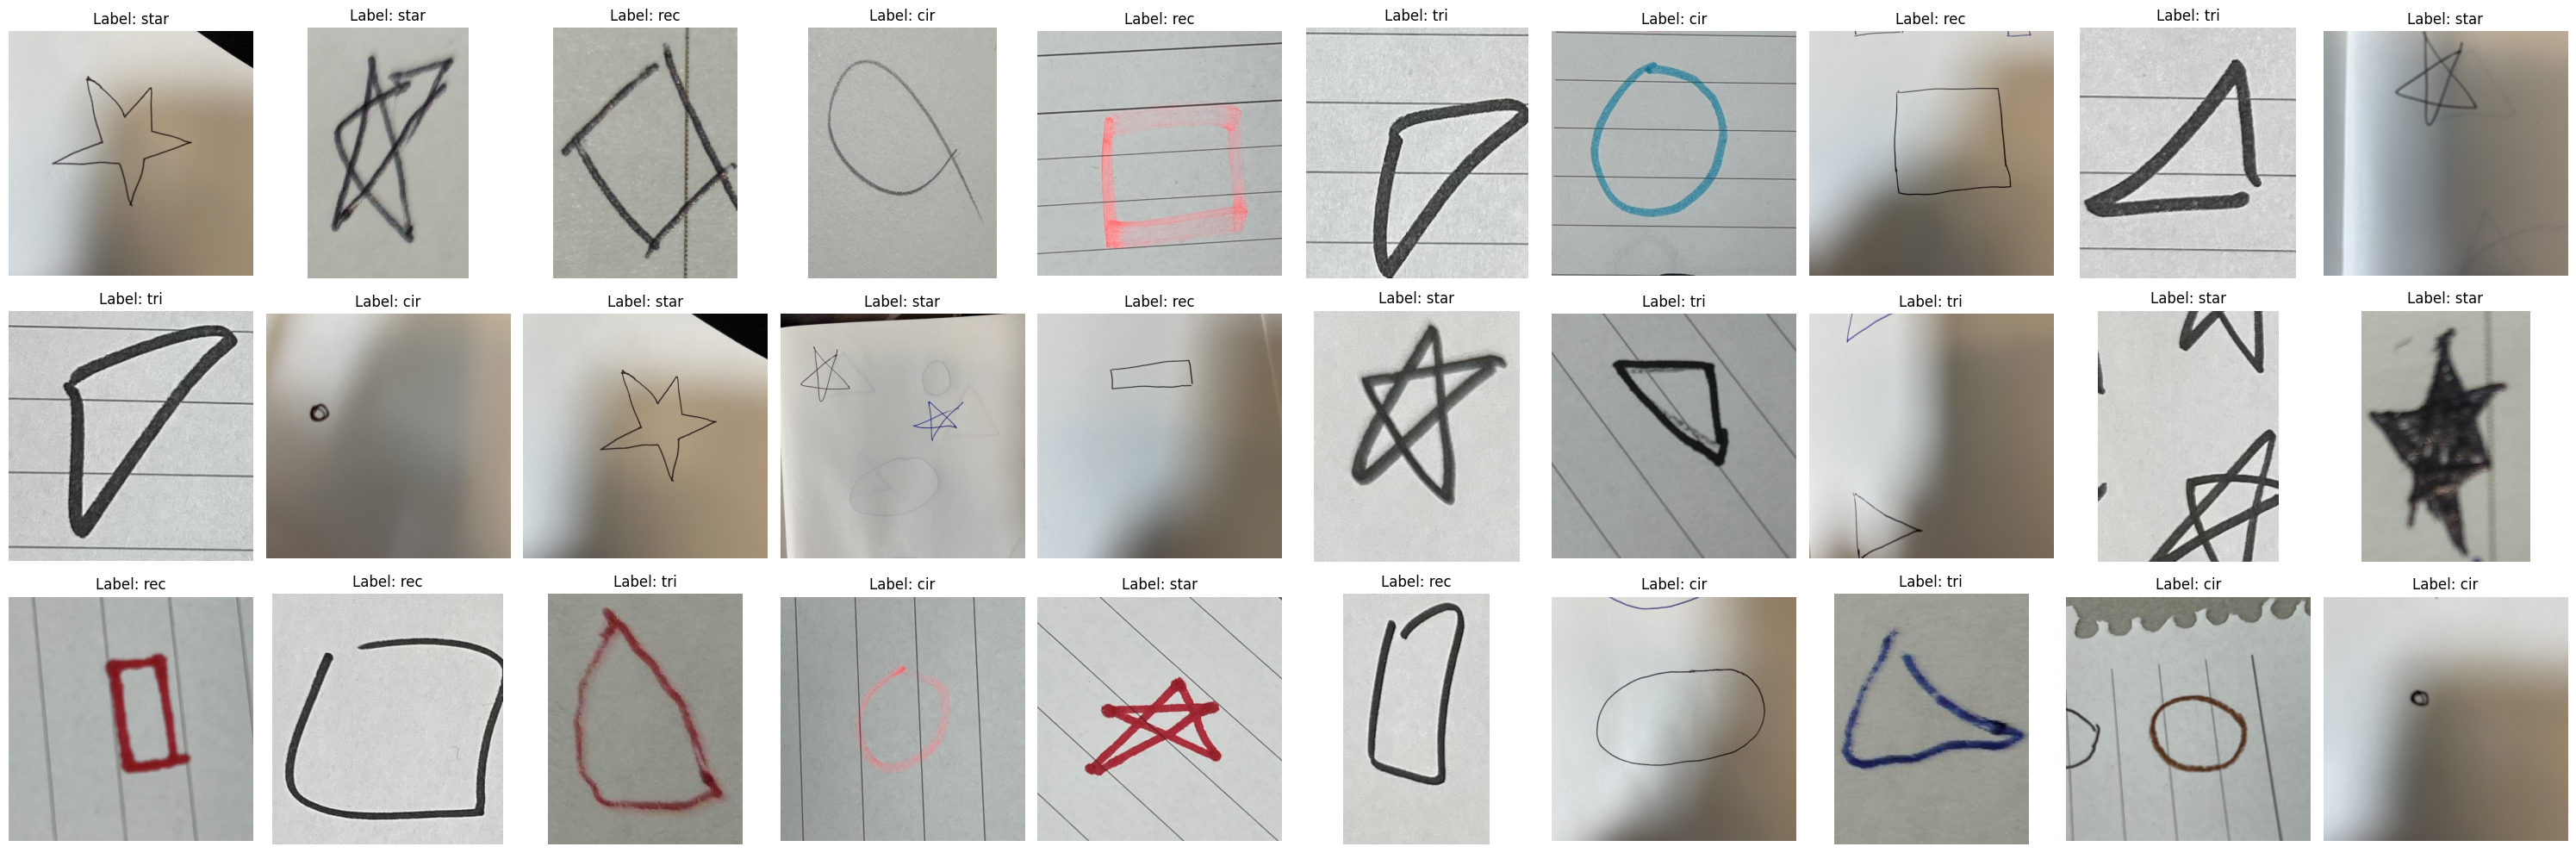

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

# 그림 생성
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(30, 10))

# 이미지 파일 경로
image_folder = "/home/kkyu/amr_ws/DL/data/shape_figure/train/"

# 30개의 이미지와 라벨 표시
for i in range(3):
    for j in range(10):
        idx = i * 10 + j  # 인덱스 계산
        if idx < len(train_df):
            # 이미지 로드
            image_filepath = image_folder + train_df["file"].iloc[idx]
            image = Image.open(image_filepath)
            
            # 이미지 표시
            axes[i, j].imshow(image)
            axes[i, j].axis('off')  # 축 제거
            
            # 해당 이미지의 라벨 표시
            label = train_df["label"].iloc[idx]
            axes[i, j].set_title("Label: " + label)

plt.tight_layout()  # 레이아웃 조정
plt.show()


In [31]:
test_df = pd.DataFrame({"file": os.listdir("/home/kkyu/amr_ws/DL/data/shape_figure/test")})
test_df["label"] = test_df["file"].apply(lambda x: x.split(".")[0])
test_df["label"] = test_df["label"].str.replace('\d+', '', regex=True)

# label 열의 값을 변경
label_map = {
    'stars': 'star',
    'rect': 'rec',
    'circles': 'cir',
    'tris': 'tri'
}
test_df["label"] = test_df["label"].map(label_map)

test_df


,file,label
0,rect175.jpg,rec
1,rect169.jpg,rec
2,stars196.jpg,star
3,rect119.jpg,rec
4,circles152.jpg,cir
...,...,...
197,rect34.jpg,rec
198,tris40.jpg,tri
199,rect124.jpg,rec
200,circles14.jpg,cir


In [32]:
train_df.shape, test_df.shape

((801, 2), (202, 2))

In [60]:
from keras.preprocessing.image import ImageDataGenerator
FILES = "/home/kkyu/amr_ws/DL/data/shape_figure/train"
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                directory = FILES,
                                                x_col = "file",
                                                y_col = "label",
                                                class_mode = "categorical",
                                                target_size = (150, 150),
                                                batch_size = batch_size,
                                                seed = 13)

FILES2 = "/home/kkyu/amr_ws/DL/data/shape_figure/test"
val_gen  = train_datagen.flow_from_dataframe(dataframe = test_df,
                                                directory = FILES2,
                                                x_col = "file",
                                                y_col = "label",
                                                class_mode = "categorical",
                                                target_size = (150, 150),
                                                batch_size = batch_size,
                                                seed = 13,
                                                shuffle = False)

Found 801 validated image filenames belonging to 4 classes.
Found 202 validated image filenames belonging to 4 classes.


In [61]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))


# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=4, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

cnn.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 dense_10 (Dense)            (None, 36, 36, 512)       16896     
                                                                 
 flatten_5 (Flatten)         (None, 663552)           

In [63]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 30)

Epoch 1/30
26/26 [==============================] - 36s 1s/step - loss: 0.5434 - accuracy: 0.7728 - val_loss: 1.8126 - val_accuracy: 0.4356
Epoch 2/30
26/26 [==============================] - 37s 1s/step - loss: 0.6435 - accuracy: 0.7603 - val_loss: 1.7046 - val_accuracy: 0.4257
Epoch 3/30
26/26 [==============================] - 30s 1s/step - loss: 0.6459 - accuracy: 0.7491 - val_loss: 2.1627 - val_accuracy: 0.4455
Epoch 4/30
26/26 [==============================] - 30s 1s/step - loss: 0.5342 - accuracy: 0.8002 - val_loss: 2.6680 - val_accuracy: 0.4455
Epoch 5/30
26/26 [==============================] - 33s 1s/step - loss: 0.3521 - accuracy: 0.8664 - val_loss: 2.8834 - val_accuracy: 0.4257
Epoch 6/30
26/26 [==============================] - 36s 1s/step - loss: 0.4473 - accuracy: 0.8514 - val_loss: 2.5100 - val_accuracy: 0.4109
Epoch 7/30
26/26 [==============================] - 33s 1s/step - loss: 0.3359 - accuracy: 0.8752 - val_loss: 3.5192 - val_accuracy: 0.4554
Epoch 8/30
26/26 [==

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# sns.lineplot(x = range(len(history.history["loss"])),
#              y = history.history["loss"], ax = axes[0],
#              label = "Training Loss" )
# sns.lineplot(x = range(len(history.history["loss"])),
#              y = history.history["val_loss"], ax = axes[0],
#              label = "Validation Loss")

# sns.lineplot(x = range(len(history.history["accuracy"])),
#              y = history.history["accuracy"], ax = axes[1],
#              label = "Training Accuracy")
# sns.lineplot(x = range(len(history.history["accuracy"])),
#              y = history.history["val_accuracy"], ax = axes[1],
#              label = "Validation Accuracy")
# axes[0].set_title("LOSS");axes[1].set_title("Accuracy")

# sns.despine()
# plt.show()
